## Importing Libraries,Dataset

In [1]:
import nltk
nltk.download('stopwords')
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seshi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_bodies=pd.read_csv('train_bodies.csv')
train_stances=pd.read_csv('train_stances.csv')

In [3]:
train_data=pd.merge(train_bodies,train_stances,how='left',on='Body ID')

In [4]:
test_stance = pd.read_csv('competition_test_stances.csv')
test_body = pd.read_csv('test_bodies.csv')

In [5]:
test_data  = pd.merge( test_body, test_stance,how='left', on='Body ID')

In [6]:
target={'unrelated':0, 'agree':1, 'discuss':2, 'disagree':3}
train_data['Stance']=train_data['Stance'].map(target)

In [7]:
train_data

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",0
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,0
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,0
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,0
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,0
...,...,...,...,...
49967,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",1
49968,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",1
49969,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",1
49970,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,1


In [8]:
test_data['Stance']=test_data['Stance'].map(target)

In [9]:
#unpreprocessed train data
xtrain_unprepdata=train_data[['Headline','articleBody']]
ytrain_unprepdata=train_data['Stance']
#unpreprocessed text data
xtest_unprepdata=test_data[['Headline','articleBody']]
ytest_unprepdata=test_data['Stance']

## Text to Sequence and Word Embedding

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
X_train_combined = train_data['Headline'] + train_data['articleBody']
X_train_combined = pd.DataFrame(X_train_combined)
X_train_combined.columns = ['combined']

In [11]:
tokens1=[]
def tokens(text):
    tokens=word_tokenize(text)
    tokens1.append(tokens)
X_train_combined['combined'].apply(tokens)

0        None
1        None
2        None
3        None
4        None
         ... 
49967    None
49968    None
49969    None
49970    None
49971    None
Name: combined, Length: 49972, dtype: object

In [12]:
tokenizer = Tokenizer(num_words=len(tokens1))
tokenizer.fit_on_texts(X_train_combined['combined'])
words_to_index = tokenizer.word_index

In [14]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
  return word_to_vec_map

In [15]:
word_to_vec_map = read_glove_vector('glove.6B.100d.txt')

In [16]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector


In [17]:
count=[]
def max_len(text):
    count.append(len(text.split()))
X_train_combined['combined'].apply(max_len)
max(count)

4804

## CNN-LSTM Model

In [27]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Input, Lambda, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
from keras.layers import concatenate,dot
from keras.utils import pad_sequences

In [19]:
train_head = tokenizer.texts_to_sequences(train_data['Headline'])
train_head = pad_sequences(train_head, maxlen=30, padding='post')
train_body = tokenizer.texts_to_sequences(train_data['articleBody'])
train_body = pad_sequences(train_body, maxlen=500, padding='post')
test_head = tokenizer.texts_to_sequences(test_data['Headline'])
test_head = pad_sequences(test_head, maxlen=30, padding='post')
test_body = tokenizer.texts_to_sequences(test_data['articleBody'])
test_body = pad_sequences(test_body, maxlen=500, padding='post')

In [80]:
result = pd.concat([pd.DataFrame(train_head), pd.DataFrame(train_body)], axis=1, join='inner')
y_train = train_data['Stance']

In [81]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
result,y_train  = sm.fit_resample(result, y_train)

In [87]:
from keras.layers import Reshape
head_input = Input(shape=(30,), dtype='int32', name='head_input')
body_input = Input(shape=(500,), dtype='int32', name='body_input')
embedding_layer = Embedding(len(words_to_index),100,weights=[emb_matrix],input_length=max(count),trainable=False)
head_embed = embedding_layer(head_input)
body_embed = embedding_layer(body_input)

pool_1 = MaxPooling1D(pool_size=3, strides=2, name='pool3')
conv_1 = Conv1D(64, 5, activation='relu', name='conv1')
head_CNN = conv_1(head_embed)
head_CNN = pool_1(head_CNN)
head_CNN = Flatten()(head_CNN)
conv_2 = Conv1D(64, 5, activation='relu', name='conv2')
body_CNN = conv_2(body_embed)
body_CNN = pool_1(body_CNN)
body_CNN = Flatten()(body_CNN)
conc = concatenate([head_CNN,body_CNN])

lstm_input = Reshape((-1, conc.shape[1]))(conc)
lstm = LSTM(32)(lstm_input)

dense = Dense(100,activation='relu')(lstm)
dense = Dropout(0.3)(dense)
dense = Dense(4,activation='softmax')(dense)
model = Model(inputs=[head_input,body_input], outputs=[dense])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['acc'])
print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 head_input (InputLayer)        [(None, 30)]         0           []                               
                                                                                                  
 body_input (InputLayer)        [(None, 500)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        multiple             4973900     ['head_input[0][0]',             
                                                                  'body_input[0][0]']             
                                                                                                  
 conv1 (Conv1D)                 (None, 26, 64)       32064       ['embedding_8[0][0]']      

In [84]:
test_x = pd.concat([pd.DataFrame(test_head), pd.DataFrame(test_body)], axis=1, join='inner')

In [88]:
model.fit([result.iloc[:,:30],result.iloc[:,30:]],y_train,validation_data = ([test_x.iloc[:,:30],test_x.iloc[:,30:]],ytest_unprepdata),epochs=4, batch_size=128,verbose = True)

Epoch 1/4
1143/1143 [==============================] - 523s 444ms/step - loss: 0.6199 - acc: 0.7464 - val_loss: 1.5126 - val_acc: 0.5148
Epoch 2/4
1143/1143 [==============================] - 502s 439ms/step - loss: 0.3566 - acc: 0.8631 - val_loss: 2.2764 - val_acc: 0.4258
Epoch 3/4
1143/1143 [==============================] - 464s 406ms/step - loss: 0.2628 - acc: 0.9009 - val_loss: 2.2047 - val_acc: 0.4846
Epoch 4/4
1143/1143 [==============================] - 462s 404ms/step - loss: 0.2066 - acc: 0.9238 - val_loss: 2.3194 - val_acc: 0.4714


In [89]:
y_pred = model.predict([test_x.iloc[:,:30],test_x.iloc[:,30:]])

795/795 [==============================] - 32s 37ms/step


In [90]:
labels = np.argmax(y_pred, axis=-1)    
print(labels)

[0 3 0 ... 0 3 0]


In [91]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest_unprepdata,labels)
cm

array([[9000, 2872, 5989,  488],
       [ 626,  575,  623,   79],
       [1336,  652, 2374,  102],
       [ 227,  151,  288,   31]], dtype=int64)

<AxesSubplot:>

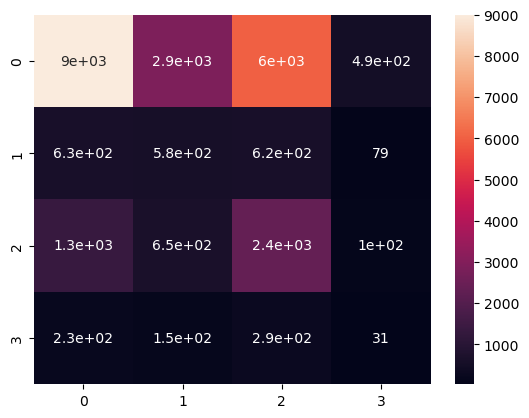

In [92]:
import seaborn as sns
sns.heatmap(cm, annot=True)